In [4]:
import json
import jiwer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [5]:
# Función auxiliar para asegurarse de que siempre se obtiene una lista de tokens
def safe_split(x):
    if isinstance(x, str):
        tokens = x.split()
        return tokens if tokens else ["<EMPTY>"]
    return x

# Función para calcular el Token Error Rate (Word Error Rate)
def compute_token_error_rate(reference, hypothesis):
    # Componer la transformación para normalizar ambos textos
    transformation = jiwer.Compose([
        jiwer.ExpandCommonEnglishContractions(),
        jiwer.RemoveEmptyStrings(),
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.RemovePunctuation(),
        jiwer.ReduceToListOfListOfWords()
    ])
    # Calcula el Word Error Rate
    error_rate = jiwer.wer(
        reference, 
        hypothesis, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    return error_rate

# Función para calcular el BLEU
def compute_bleu(reference, hypothesis):
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothie)
    return bleu_score

# Función para calcular ROUGE-L
def compute_rouge(reference, hypothesis):
    rouge_evaluator = Rouge()
    scores = rouge_evaluator.get_scores(hypothesis, reference)
    rouge_l = scores[0]['rouge-l']['f']
    return rouge_l

# Función para calcular las métricas para cada respuesta
def calculate_metrics(results):
    for result in results:
        expected = result["expected_answer"].strip()
        generated = result["generated_answer"].strip()
        
        result["token_error_rate"] = compute_token_error_rate(expected, generated)
        result["bleu_score"] = compute_bleu(expected, generated)
        try:
            result["rouge_l"] = compute_rouge(expected, generated)
        except Exception as e:
            result["rouge_l"] = None
            print(f"Error al calcular ROUGE: {e}")
    return results

In [6]:
# Abrir los archivos JSON con los resultados
with open("non_expert_results.json", "r", encoding="utf-8") as f:
    non_expert_results = json.load(f)

with open("expert_results.json", "r", encoding="utf-8") as f:
    expert_results = json.load(f)

In [7]:
# Calcular métricas para cada conjunto
non_expert_results = calculate_metrics(non_expert_results)
expert_results = calculate_metrics(expert_results)

In [8]:
# Imprimir resultados para verificación
print("Resultados para preguntas no expertas con métricas:")
for res in non_expert_results:
    print(res)
    
print("\nResultados para preguntas expertas con métricas:")
for res in expert_results:
    print(res)

Resultados para preguntas no expertas con métricas:
{'question': '¿Qué son los riesgos ESG?', 'expected_answer': 'Son aquellos riesgos relacionados con factores ambientales, sociales y de gobernanza que pueden afectar la estabilidad y funcionamiento de las instituciones financieras, incluyendo riesgos derivados de la transición hacia economías sostenibles y riesgos físicos (como eventos climáticos extremos).', 'generated_answer': 'Los riesgos ESG son:\n\nRiesgos ambientales, sociales y de gobernanza.', 'token_error_rate': 0.8421052631578947, 'bleu_score': 0.01689071874072545, 'rouge_l': 0.29268292314098754}
{'question': '¿Cuál es el objetivo principal de estas directrices ESG?', 'expected_answer': 'Establecer estándares mínimos y metodologías de referencia para identificar, medir, gestionar y monitorizar los riesgos ESG en las instituciones.', 'generated_answer': 'El objetivo principal de estas directrices ESG es:\n\nGestionar riesgos ESG', 'token_error_rate': 0.7894736842105263, 'bleu

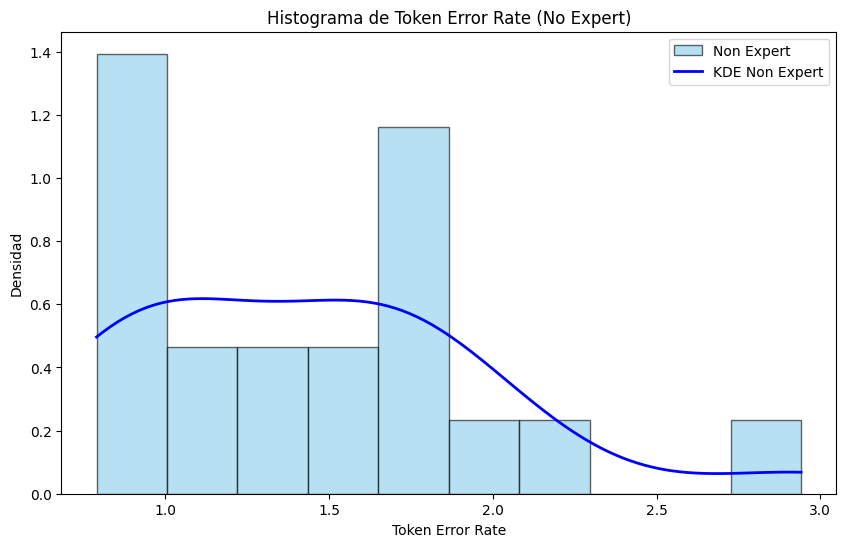

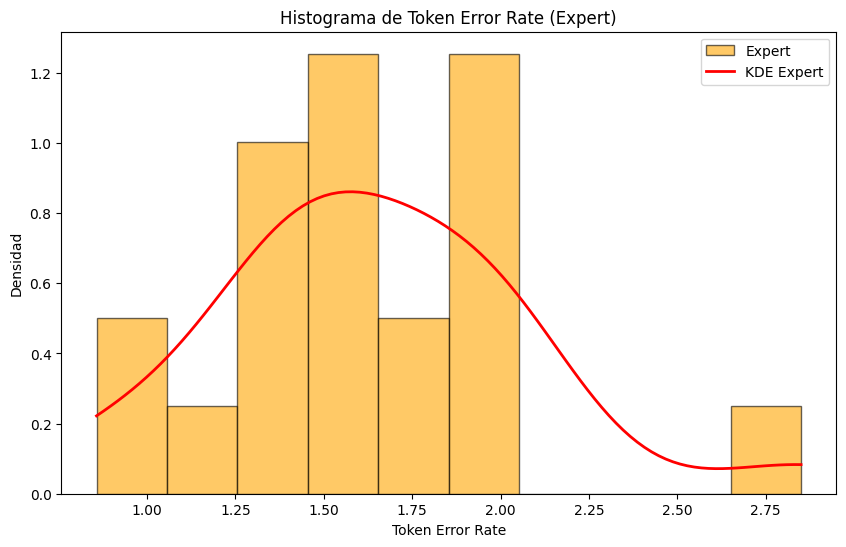

In [9]:
# Extraer token_error_rate para cada conjunto
non_expert_error_rates_advanced = [result['token_error_rate'] for result in non_expert_results]
expert_error_rates_advanced = [result['token_error_rate'] for result in expert_results]

# Histograma para preguntas no expertas
plt.figure(figsize=(10, 6))
# Se usa un color (skyblue) para no expert
counts, bins, patches = plt.hist(non_expert_error_rates_advanced, bins=10, density=True, 
                                 alpha=0.6, color='skyblue', edgecolor='black', label='Non Expert')
# Calcular y graficar la curva KDE
kde_non_expert = gaussian_kde(non_expert_error_rates_advanced)
x_vals_non_expert = np.linspace(min(non_expert_error_rates_advanced), max(non_expert_error_rates_advanced), 100)
plt.plot(x_vals_non_expert, kde_non_expert(x_vals_non_expert), color='blue', linewidth=2, label='KDE Non Expert')
plt.title("Histograma de Token Error Rate (No Expert)")
plt.xlabel("Token Error Rate")
plt.ylabel("Densidad")
plt.legend()
plt.show()

# Histograma para preguntas expertas
plt.figure(figsize=(10, 6))
# Se usa otro color (orange) para expert
counts, bins, patches = plt.hist(expert_error_rates_advanced, bins=10, density=True, 
                                 alpha=0.6, color='orange', edgecolor='black', label='Expert')
# Calcular y graficar la curva KDE
kde_expert = gaussian_kde(expert_error_rates_advanced)
x_vals_expert = np.linspace(min(expert_error_rates_advanced), max(expert_error_rates_advanced), 100)
plt.plot(x_vals_expert, kde_expert(x_vals_expert), color='red', linewidth=2, label='KDE Expert')
plt.title("Histograma de Token Error Rate (Expert)")
plt.xlabel("Token Error Rate")
plt.ylabel("Densidad")
plt.legend()
plt.show()

In [12]:
# Guardar los resultados enriquecidos en nuevos archivos JSON
with open("non_expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(non_expert_results, f, ensure_ascii=False, indent=4)

with open("expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(expert_results, f, ensure_ascii=False, indent=4)


In [13]:
# Abrir los archivos JSON con los resultados
with open("non_expert_results_advanced.json", "r", encoding="utf-8") as f:
    non_expert_results_advanced = json.load(f)

with open("expert_results_advanced.json", "r", encoding="utf-8") as f:
    expert_results_advanced = json.load(f)


In [14]:
# Calcular métricas para cada conjunto
non_expert_results_advanced = calculate_metrics(non_expert_results_advanced)
expert_results_advanced = calculate_metrics(expert_results_advanced)
# Imprimir resultados para verificación
print("Resultados avanzados para preguntas no expertas con métricas:")
for res in non_expert_results_advanced:
    print(res)

print("\nResultados avanzados para preguntas expertas con métricas:")
for res in expert_results_advanced:
    print(res)


Resultados avanzados para preguntas no expertas con métricas:
{'question': '¿Qué son los riesgos ESG?', 'expected_answer': 'Son aquellos riesgos relacionados con factores ambientales, sociales y de gobernanza que pueden afectar la estabilidad y funcionamiento de las instituciones financieras, incluyendo riesgos derivados de la transición hacia economías sostenibles y riesgos físicos (como eventos climáticos extremos).', 'generated_answer': 'Los riesgos ESG se refieren a:\n\n- Riesgos ambientales (Environmental)\n- Riesgos sociales (Social) \n- Riesgos de gobernanza (Governance)', 'token_error_rate': 0.9210526315789473, 'bleu_score': 0.013593007098176466, 'rouge_l': 0.17391303908317593}
{'question': '¿Cuál es el objetivo principal de estas directrices ESG?', 'expected_answer': 'Establecer estándares mínimos y metodologías de referencia para identificar, medir, gestionar y monitorizar los riesgos ESG en las instituciones.', 'generated_answer': 'El objetivo principal es gestionar los ries

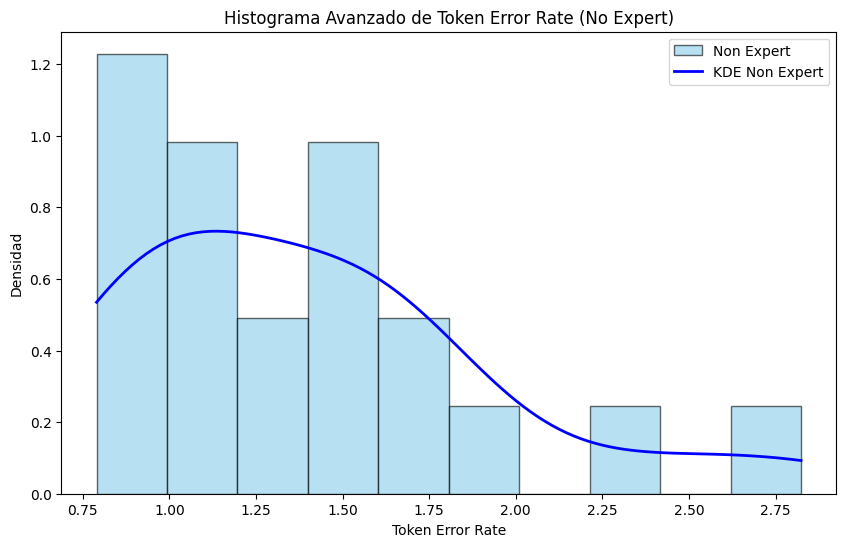

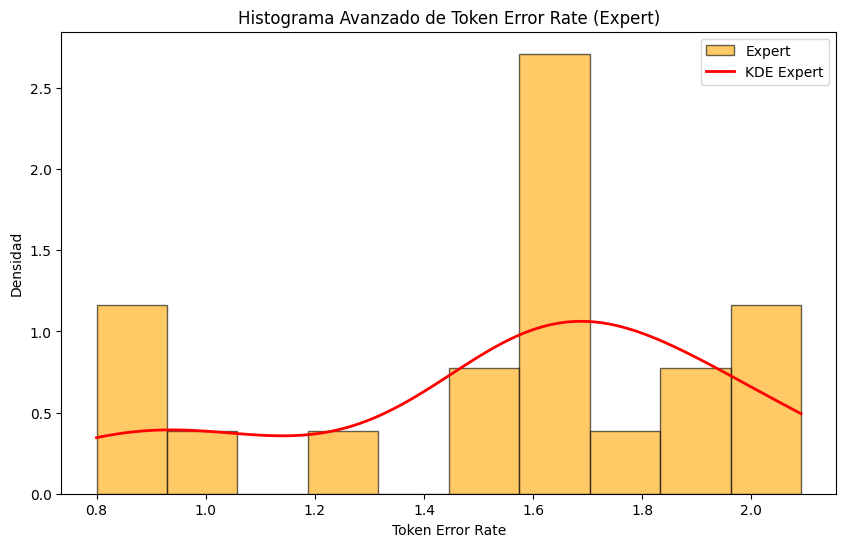

In [15]:
# Extraer token_error_rate para cada conjunto
non_expert_error_rates_advanced = [result['token_error_rate'] for result in non_expert_results_advanced]
expert_error_rates_advanced = [result['token_error_rate'] for result in expert_results_advanced]

# Histograma para preguntas no expertas
plt.figure(figsize=(10, 6))
# Se usa un color (skyblue) para no expert
counts, bins, patches = plt.hist(non_expert_error_rates_advanced, bins=10, density=True, 
                                 alpha=0.6, color='skyblue', edgecolor='black', label='Non Expert')
# Calcular y graficar la curva KDE
kde_non_expert = gaussian_kde(non_expert_error_rates_advanced)
x_vals_non_expert = np.linspace(min(non_expert_error_rates_advanced), max(non_expert_error_rates_advanced), 100)
plt.plot(x_vals_non_expert, kde_non_expert(x_vals_non_expert), color='blue', linewidth=2, label='KDE Non Expert')
plt.title("Histograma Avanzado de Token Error Rate (No Expert)")
plt.xlabel("Token Error Rate")
plt.ylabel("Densidad")
plt.legend()
plt.show()

# Histograma para preguntas expertas
plt.figure(figsize=(10, 6))
# Se usa otro color (orange) para expert
counts, bins, patches = plt.hist(expert_error_rates_advanced, bins=10, density=True, 
                                 alpha=0.6, color='orange', edgecolor='black', label='Expert')
# Calcular y graficar la curva KDE
kde_expert = gaussian_kde(expert_error_rates_advanced)
x_vals_expert = np.linspace(min(expert_error_rates_advanced), max(expert_error_rates_advanced), 100)
plt.plot(x_vals_expert, kde_expert(x_vals_expert), color='red', linewidth=2, label='KDE Expert')
plt.title("Histograma Avanzado de Token Error Rate (Expert)")
plt.xlabel("Token Error Rate")
plt.ylabel("Densidad")
plt.legend()
plt.show()

In [16]:
# Guardar los resultados enriquecidos en nuevos archivos JSON
with open("non_expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(non_expert_results_advanced, f, ensure_ascii=False, indent=4)

with open("expert_results_with_metrics.json", "w", encoding="utf-8") as f:
    json.dump(expert_results_advanced, f, ensure_ascii=False, indent=4)